# Sentiment Analysis using Scikit-Learn

## Introduction
This project details how machine learning can be used to classify Amazon reviews as having positive or negative sentiment. in addition, it explores the pre-processing steps involved with text classification.

My goal was to learn more about natural language processing and preparing text data for machine learning. Also, I wanted to see how pre-processing affects a machine learning model's accuracy.

In [51]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn import svm
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from SpellCheck import get_correction
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud

## Selection of Data
The data has 1000 samples of excerpts from Amazon reviews with sentiment labels (positive or negative). Half of the samples are positive and half are negative. The dataset can be found on the UCI Machine Learning Repository [1]

The objective is to label each text as having positive or negative sentiment.

In [56]:
with open('./english_contractions.json') as f:
    contractions = json.load(f)

amazon_data = pd.read_csv('data/amazon_labelled.txt', sep="\t")

positive_reviews = amazon_data.iloc[:, 1] == 1
positive_reviews = amazon_data[positive_reviews].iloc[:, 0]
num_positive = positive_reviews.shape[0]

negative_reviews = amazon_data.iloc[:, 1] == 0
negative_reviews = amazon_data[negative_reviews].iloc[:, 0]
num_negative = negative_reviews.shape[0]

print("There are %s positive reviews and %s negative reviews" % (num_positive, num_negative))

There are 500 positive reviews and 499 negative reviews


### Preview of Data

In [57]:
print(positive_reviews.head(10))
# print(negative_reviews.head(10))

0                           Good case, Excellent value.
1                                Great for the jawbone.
3                                     The mic is great.
6           If you are Razr owner...you must have this!
9                       And the sound quality is great.
10    He was very impressed when going from the orig...
12                             Very good quality though
14    Highly recommend for any one who has a blue to...
16                                     So Far So Good!.
17                                        Works great!.
Name: So there is no way for me to plug it in here in the US unless I go by a converter., dtype: object


### Characteristics of Data
As it is, the text has:
- Misspellings ("I purcashed this", "I definitly recommend", "I bougth it")
- Punctutation (periods, commas, exclamations, hyphens)
- Contractions (I've, don't, can't)

As a result, the text needs to be pre-processed before fitting a model. The pre-processing steps I took include:
- Converting the text to lower case
- Removing punctuation
- Tokenizing the text and for each word:
    * Correct spelling if necessary
    * Convert contractions to a common form ("don't", "dont" become "do not")
    * Lemmatize each word

Lemmatization converts words into a common form. For example, "purchase", "purchasing", "purchased" all become "purchase"

In [65]:
# Regular expression tokenizer - splits text according to word characters
# Ignores punctuation and numbers
tokenizer = RegexpTokenizer(r"[a-z']+")
lemmatizer = WordNetLemmatizer()
example_text = "looking, looked...look"
example_tokens = tokenizer.tokenize(example_text)
print(example_tokens)
for word in example_tokens:
    print(lemmatizer.lemmatize(word, pos='v'))

['looking', 'looked', 'look']
look
look
look


In [66]:
def preprocess_text(text):
    text = text.lower()
    tokens = tokenizer.tokenize(text)
    for i in range(len(tokens)):
        if tokens[i] in contractions.keys():
            tokens[i] = contractions[tokens[i]]
        else:
            tokens[i] = get_correction(tokens[i])
        tokens[i] = lemmatizer.lemmatize(tokens[i], pos='v')
    return " ".join(tokens)

In [67]:
sample_a = "I purcashed this for the car charger and it does not work."
sample_b = "Don't trust their website and don't expect any helpful support."
print(preprocess_text(sample_b))

do not trust their website and do not expect any helpful support


## Methods
The tools I used include:
- nltk for tokenization
- symspellpy for spelling correction
- Pandas and scikit-learn for machine learning

I used the linear support vector classifier (linearSVC) model from scikit-learn

### TF-IDF
Before fitting the model, the text is transformed into a TF-IDF matrix. TF-IDF, or term frequency-inverse document frequency, is a way to measure the importance of a word in a set of documents, or a corpus.

To simplify my code, I created a pipeline. The pandas dataframe is converted into a TF-IDF matrix and fitted to the LinearSVC model.

In [68]:
model = make_pipeline(TfidfVectorizer(ngram_range=(1, 2)), svm.LinearSVC())

## Results

In [69]:
X = amazon_data.iloc[:, 0]
X = X.apply(preprocess_text)
y = amazon_data.iloc[:, 1]

scores = cross_val_score(model, X, y, cv=5)
print(scores)
print(np.mean(scores))

[0.89       0.865      0.835      0.825      0.83417085]
0.8498341708542714


After pre-processing the text, the model's accuracy increases from around 83% to 85%. Below are the top words from the positive and negative reviews: 

In [70]:
from IPython.display import Image
def generate_wordcloud(file_name, bgcolor, text):
    wc = WordCloud(
        background_color = bgcolor,
        height=400,
        width=400
    )
    wc.generate(text)
    wc.to_file(file_name)

In [71]:
tfidf = TfidfVectorizer(ngram_range=(1,1), max_features=15, stop_words='english')

### Positive reviews:

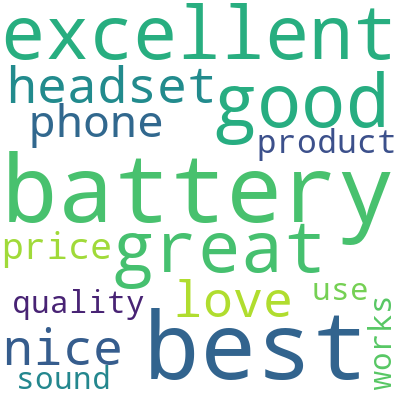

In [72]:
tfidf.fit_transform(positive_reviews)
positive_words = tfidf.get_feature_names()
positive_words = " ".join(positive_words)
generate_wordcloud('positive.png', 'white', positive_words)
Image('positive.png')

### Negative reviews:

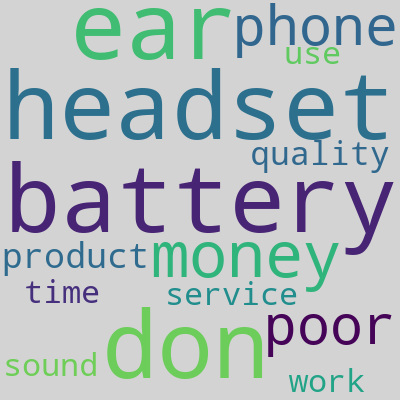

In [73]:
tfidf.fit_transform(negative_reviews)
negative_words = tfidf.get_feature_names()
negative_words = " ".join(negative_words)
generate_wordcloud('negative.png', 'lightgray', negative_words)
Image('negative.png')

## Discussion
After testing different models (MultinomialNB, DecisionTreeClassifier, LinearSVC), I found LinearSVC to be the most accurate. With all the models, accuracy increased slightly after pre-processing.

I encountered a few issues when attempting to pre-process the data. First, I attempted to split sentences by spacing and punctuation. However, contractions like “I’ve” would be split into two separate tokens, “I” and “‘ve”. Instead, I used nltk’s RegExpTokenizer to split words according to word characters and apostrophes. Then, contractions would remain a single token and I could convert them to a single common form.


# Summary
This project explored the different pre-processing steps that can be done before fitting a machine learning model to text data. Lowercasing text, correcting spelling, converting contractions to a common form,
and lemmatizing words all helped to increase the accuracy of the model. After these steps, the LinearSVC model's accuracy increased from around 83% to 85%

In addition, TF-IDF can be used to determine the most "important" words in a document, and is useful in text classification tasks.


## References
[1] 'From Group to Individual Labels using Deep Features', Kotzias et. al,. KDD 2015 - [Dataset link](https://archive.ics.uci.edu/ml/datasets/Sentiment+Labelled+Sentences)

[Preprocessing text in Python](https://towardsdatascience.com/preprocessing-text-in-python-923828c4114f) - Used to help understand tokenizing and lemmatizing using NLTK

[Python Data Science Handbook - Feature Engineering
](https://jakevdp.github.io/PythonDataScienceHandbook/05.04-feature-engineering.html) - Used to help learn how to use scikit-learn for text classification

[Text Normalization](https://towardsdatascience.com/text-normalization-7ecc8e084e31) - Used to help understand text normalization and for the [english_contractions.json file](https://gist.githubusercontent.com/Sirsirious/c70400176a4532899a483e06d72cf99e/raw/e46fa7620c4f378f5bf39608b45cddad7ff447a4/english_contractions.json)
